In [1]:
import os
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#pd.options.display.max_columns = None

### Getting ipblocks data

In [2]:
#ipblocks = pd.read_csv("/home/ec2-user/SageMaker/s3fs-fuse/bucket/wiki_trust/ipblocks_revised.txt",sep='\t')
ipblocks = pd.read_csv("/home/ec2-user/SageMaker/bucket/wiki_trust/ipblocks_fulldump_new.csv")
del ipblocks['Unnamed: 0']
ipblocks.tail()

,ipb_id,ipb_user,ipb_address,ipb_create_account,ipb_expiry,date,ipb_reason
1130480,8666553,0,192.12.147.74,1,2.01811E+13,20181101,NaN
1130481,8666554,35029872,Drm!es Buy Meth In Garden City Form Dead Birds,1,infinity,20181101,NaN
1130482,8666555,0,NaN,1,2.01811E+13,20181101,NaN
1130483,8666558,35029888,WhenDatMethLabBling,1,infinity,20181101,NaN
1130484,8666559,0,NaN,1,2.01811E+13,20181101,NaN


In [3]:
ipblocks[ipblocks['ipb_address']=='Kumioko']

,ipb_id,ipb_user,ipb_address,ipb_create_account,ipb_expiry,date,ipb_reason
653241,5108791,16675924,Kumioko,0,infinity,20140601,User has been banned by the community - see [[...


In [4]:
ipblocks[ipblocks['ipb_address']=='INeverCry']

,ipb_id,ipb_user,ipb_address,ipb_create_account,ipb_expiry,date,ipb_reason
939964,7725373,8681972,INeverCry,1,infinity,20170811,"Abuse of multiple accounts, see: [[Wikipedia:S..."


In [3]:
df_all = ipblocks[ipblocks['date'] >= 20170301]
df_all2 = df_all[df_all['date'] < 20180900]
df_all_userlist=df_all2['ipb_address']

In [7]:
df_all_userlist.count()

169455

### Sample run of loading revision file and adding blocked column

In [5]:
rev = pd.read_csv("/home/ec2-user/SageMaker/s3fs-fuse/bucket/wiki_trust/revisions_data/revision1.txt",sep='\t')
rev.head()

,rev_id,rev_page,rev_comment_id,rev_parent_id,rev_user,rev_user_text,rev_timestamp,rev_minor_edit,rev_deleted,rev_len
0,818010128,11897833,269491,139891326,196446.0,BD2412,20180101000000,1,0,6.0
1,818010129,39342799,81614,818009989,0.0,41.29.138.138,20180101000000,0,0,7430.0
2,818010130,25485115,72642,818007424,738200.0,James Allison,20180101000000,0,0,1727.0
3,818010131,36544037,38929,818010120,29088686.0,DatBot,20180101000000,0,0,525.0
4,818010132,55831793,10,817999703,30421931.0,Henry Detjen,20180101000001,0,0,16882.0


In [6]:
rev['blocked'] = np.where(rev['rev_user_text'].isin(df_all_userlist),1,0)

In [7]:
rev['blocked'].value_counts()

0    970339
1     29661
Name: blocked, dtype: int64

### Getting structure of revisions

In [8]:
rev_all = rev[rev['blocked']==2]

In [9]:
rev_all

,rev_id,rev_page,rev_comment_id,rev_parent_id,rev_user,rev_user_text,rev_timestamp,rev_minor_edit,rev_deleted,rev_len,blocked


### Loading all files one by one and filtering the blocked user revisions into a single dataframe

In [10]:
path = "/home/ec2-user/SageMaker/s3fs-fuse/bucket/wiki_trust/revisions_data/"                                  # where files are stored
file_list = [x for x in os.listdir("/home/ec2-user/SageMaker/s3fs-fuse/bucket/wiki_trust/revisions_data/") 
             if x.endswith(".txt") ]

In [11]:
#file_list_small = file_list [0:3]
for file in file_list:
    revision_file = str(path) + str(file)
    rev = pd.read_csv(revision_file,sep='\t')
    rev['blocked'] = np.where(rev['rev_user_text'].isin(df_all_userlist),1,0)
    rev_new = rev[rev['blocked']==0]
    #rev_new = rev[rev['blocked']==1]
    frames = [rev_all, rev_new]
    rev_all = pd.concat(frames)

In [9]:
rev_all.count()

rev_id            3019710
rev_page          3019710
rev_comment_id    3019710
rev_parent_id     3019710
rev_user          3019710
rev_user_text     3019710
rev_timestamp     3019710
rev_minor_edit    3019710
rev_deleted       3019710
rev_len           2995030
blocked           3019710
rev_date          3019710
dtype: int64

In [13]:
rev_all.to_csv('/home/ec2-user/SageMaker/s3fs-fuse/bucket/wiki_trust/blocked_n_nonblocked_Revisions.csv')

In [14]:
len(rev_all["rev_user_text"].unique())

6126510

### Read in file(s) again from storage

In [2]:
rev_all = pd.read_csv("/home/ec2-user/SageMaker/s3fs-fuse/bucket/wiki_trust/blockedRevisions_new.csv")
del rev_all['Unnamed: 0']
rev_all.head()

,rev_id,rev_page,rev_comment_id,rev_parent_id,rev_user,rev_user_text,rev_timestamp,rev_minor_edit,rev_deleted,rev_len,blocked
0,818010162,102136,10,818010097,32743729.0,Hekt0rino,20180101000011,0,0,44480.0,1
1,818010205,102136,10,818010162,32743729.0,Hekt0rino,20180101000028,0,0,44481.0,1
2,818010265,4848448,6506223,818006169,32744253.0,Zesharn Mahmood,20180101000059,1,0,24643.0,1
3,818010306,1051979,127552,818006488,32748940.0,TyrexJBD,20180101000118,0,0,2260.0,1
4,818010323,56182207,1893774,818010069,32748957.0,CookieMonster756,20180101000123,0,0,3829.0,1


In [2]:
rev_all_nb = pd.read_csv("/home/ec2-user/SageMaker/s3fs-fuse/bucket/wiki_trust/blocked_n_nonblocked_Revisions.csv")
del rev_all_nb['Unnamed: 0']
rev_all_nb.head()

,rev_id,rev_page,rev_comment_id,rev_parent_id,rev_user,rev_user_text,rev_timestamp,rev_minor_edit,rev_deleted,rev_len,blocked
0,818010128,11897833,269491,139891326,196446.0,BD2412,20180101000000,1,0,6.0,0
1,818010129,39342799,81614,818009989,0.0,41.29.138.138,20180101000000,0,0,7430.0,0
2,818010130,25485115,72642,818007424,738200.0,James Allison,20180101000000,0,0,1727.0,0
3,818010131,36544037,38929,818010120,29088686.0,DatBot,20180101000000,0,0,525.0,0
4,818010132,55831793,10,817999703,30421931.0,Henry Detjen,20180101000001,0,0,16882.0,0


### (A) Blocked User revisions -

### Creating column for rev_date

In [3]:
rev_all['rev_date'] = (rev_all['rev_timestamp']/1000000).astype(np.int64)
rev_all.sample(10)

,rev_id,rev_page,rev_comment_id,rev_parent_id,rev_user,rev_user_text,rev_timestamp,rev_minor_edit,rev_deleted,rev_len,blocked,rev_date
1057107,795459841,45328174,62275,783786492,29380370.0,Quinton Feldberg,20170814105350,1,0,10653.0,1,20170814
1040054,795007072,9619211,62275,794840282,29380370.0,Quinton Feldberg,20170811120551,1,0,16337.0,1,20170811
638094,783029134,10434131,239051545,783020383,16097848.0,Tyler Durden,20170530175054,0,0,18388.0,1,20170530
2356264,774500123,17919207,236968435,773378415,13128142.0,Zoupan,20170408215620,0,0,9326.0,1,20170408
116902,830488786,53161940,1648591,830487503,29769715.0,Kev519,20180315034905,0,0,37700.0,1,20180315
1031086,794805504,54836140,985623,0,29380370.0,Quinton Feldberg,20170810044031,0,0,2235.0,1,20170810
542342,780224132,53927579,415879,780223995,30684502.0,Ricdowiki95,20170513181253,0,0,10102.0,1,20170513
1735312,812585633,21561375,10,770741557,17394934.0,Renekm,20171128180815,0,0,1942.0,1,20171128
1849080,816390325,112379,10,816139562,32667996.0,Bearjewsuse,20171221011554,1,0,28446.0,1,20171221
921059,791690282,6236310,220193389,789953092,31561657.0,WikiUser8,20170721213107,1,0,15714.0,1,20170721


### Merging with date field from ipblocks

In [8]:
ipb = ipblocks.loc[:,['ipb_address','date']]
ipb.head()

,ipb_address,date
0,Wanli2,20040208
1,Xuepiao,20040208
2,GrandVoivodOfErdely,20040208
3,#1703,20040213
4,Wanli3,20040314


In [9]:
rev_all = pd.merge(rev_all,ipb,how="left",left_on=["rev_user_text"],right_on=["ipb_address"])
rev_all.head(10)

,rev_id,rev_page,rev_comment_id,rev_parent_id,rev_user,rev_user_text,rev_timestamp,rev_minor_edit,rev_deleted,rev_len,blocked,rev_date,ipb_address,date
0,818010162,102136,10,818010097,32743729.0,Hekt0rino,20180101000011,0,0,44480.0,1,20180101,Hekt0rino,20180101
1,818010205,102136,10,818010162,32743729.0,Hekt0rino,20180101000028,0,0,44481.0,1,20180101,Hekt0rino,20180101
2,818010265,4848448,6506223,818006169,32744253.0,Zesharn Mahmood,20180101000059,1,0,24643.0,1,20180101,Zesharn Mahmood,20180101
3,818010306,1051979,127552,818006488,32748940.0,TyrexJBD,20180101000118,0,0,2260.0,1,20180101,TyrexJBD,20180101
4,818010323,56182207,1893774,818010069,32748957.0,CookieMonster756,20180101000123,0,0,3829.0,1,20180101,CookieMonster756,20171231
5,818010359,54625448,616867,817693459,31561243.0,Willhargis8,20180101000140,0,0,4252.0,1,20180101,Willhargis8,20171204
6,818010509,7583940,10,812801987,32381342.0,Karl.i.biased,20180101000242,0,0,24549.0,1,20180101,Karl.i.biased,20180306
7,818010565,7583940,10,818010509,32381342.0,Karl.i.biased,20180101000309,0,0,24554.0,1,20180101,Karl.i.biased,20180306
8,818010577,13278058,50534,817892480,24420788.0,KasparBot,20180101000312,0,0,2514.0,1,20180101,KasparBot,20180730
9,818010625,1051979,4548078,818010432,32748940.0,TyrexJBD,20180101000332,0,0,2243.0,1,20180101,TyrexJBD,20180101


### Getting difference between date and rev_date

In [10]:
rev_all['date'] = pd.to_datetime(rev_all['date'], format = "%Y%m%d")

In [11]:
rev_all['rev_date'] = pd.to_datetime(rev_all['rev_date'], format = "%Y%m%d")

In [12]:
rev_all['diff_days'] = (rev_all['date']-rev_all['rev_date']).dt.days
rev_all.head(10)

,rev_id,rev_page,rev_comment_id,rev_parent_id,rev_user,rev_user_text,rev_timestamp,rev_minor_edit,rev_deleted,rev_len,blocked,rev_date,ipb_address,date,diff_days
0,818010162,102136,10,818010097,32743729.0,Hekt0rino,20180101000011,0,0,44480.0,1,2018-01-01,Hekt0rino,2018-01-01,0
1,818010205,102136,10,818010162,32743729.0,Hekt0rino,20180101000028,0,0,44481.0,1,2018-01-01,Hekt0rino,2018-01-01,0
2,818010265,4848448,6506223,818006169,32744253.0,Zesharn Mahmood,20180101000059,1,0,24643.0,1,2018-01-01,Zesharn Mahmood,2018-01-01,0
3,818010306,1051979,127552,818006488,32748940.0,TyrexJBD,20180101000118,0,0,2260.0,1,2018-01-01,TyrexJBD,2018-01-01,0
4,818010323,56182207,1893774,818010069,32748957.0,CookieMonster756,20180101000123,0,0,3829.0,1,2018-01-01,CookieMonster756,2017-12-31,-1
5,818010359,54625448,616867,817693459,31561243.0,Willhargis8,20180101000140,0,0,4252.0,1,2018-01-01,Willhargis8,2017-12-04,-28
6,818010509,7583940,10,812801987,32381342.0,Karl.i.biased,20180101000242,0,0,24549.0,1,2018-01-01,Karl.i.biased,2018-03-06,64
7,818010565,7583940,10,818010509,32381342.0,Karl.i.biased,20180101000309,0,0,24554.0,1,2018-01-01,Karl.i.biased,2018-03-06,64
8,818010577,13278058,50534,817892480,24420788.0,KasparBot,20180101000312,0,0,2514.0,1,2018-01-01,KasparBot,2018-07-30,210
9,818010625,1051979,4548078,818010432,32748940.0,TyrexJBD,20180101000332,0,0,2243.0,1,2018-01-01,TyrexJBD,2018-01-01,0


### Getting the week number

In [13]:
rev_all['diff_week'] = (np.ceil((rev_all['diff_days']+1)/7)).astype(np.int64)
rev_all.head(10)

,rev_id,rev_page,rev_comment_id,rev_parent_id,rev_user,rev_user_text,rev_timestamp,rev_minor_edit,rev_deleted,rev_len,blocked,rev_date,ipb_address,date,diff_days,diff_week
0,818010162,102136,10,818010097,32743729.0,Hekt0rino,20180101000011,0,0,44480.0,1,2018-01-01,Hekt0rino,2018-01-01,0,1
1,818010205,102136,10,818010162,32743729.0,Hekt0rino,20180101000028,0,0,44481.0,1,2018-01-01,Hekt0rino,2018-01-01,0,1
2,818010265,4848448,6506223,818006169,32744253.0,Zesharn Mahmood,20180101000059,1,0,24643.0,1,2018-01-01,Zesharn Mahmood,2018-01-01,0,1
3,818010306,1051979,127552,818006488,32748940.0,TyrexJBD,20180101000118,0,0,2260.0,1,2018-01-01,TyrexJBD,2018-01-01,0,1
4,818010323,56182207,1893774,818010069,32748957.0,CookieMonster756,20180101000123,0,0,3829.0,1,2018-01-01,CookieMonster756,2017-12-31,-1,0
5,818010359,54625448,616867,817693459,31561243.0,Willhargis8,20180101000140,0,0,4252.0,1,2018-01-01,Willhargis8,2017-12-04,-28,-3
6,818010509,7583940,10,812801987,32381342.0,Karl.i.biased,20180101000242,0,0,24549.0,1,2018-01-01,Karl.i.biased,2018-03-06,64,10
7,818010565,7583940,10,818010509,32381342.0,Karl.i.biased,20180101000309,0,0,24554.0,1,2018-01-01,Karl.i.biased,2018-03-06,64,10
8,818010577,13278058,50534,817892480,24420788.0,KasparBot,20180101000312,0,0,2514.0,1,2018-01-01,KasparBot,2018-07-30,210,31
9,818010625,1051979,4548078,818010432,32748940.0,TyrexJBD,20180101000332,0,0,2243.0,1,2018-01-01,TyrexJBD,2018-01-01,0,1


### Getting number of days each blocked user was active before blocked date

In [14]:
rev_all_ac = rev_all[rev_all['diff_days']>=0]

In [15]:
rev_all_ac.head(10)

,rev_id,rev_page,rev_comment_id,rev_parent_id,rev_user,rev_user_text,rev_timestamp,rev_minor_edit,rev_deleted,rev_len,blocked,rev_date,ipb_address,date,diff_days,diff_week
0,818010162,102136,10,818010097,32743729.0,Hekt0rino,20180101000011,0,0,44480.0,1,2018-01-01,Hekt0rino,2018-01-01,0,1
1,818010205,102136,10,818010162,32743729.0,Hekt0rino,20180101000028,0,0,44481.0,1,2018-01-01,Hekt0rino,2018-01-01,0,1
2,818010265,4848448,6506223,818006169,32744253.0,Zesharn Mahmood,20180101000059,1,0,24643.0,1,2018-01-01,Zesharn Mahmood,2018-01-01,0,1
3,818010306,1051979,127552,818006488,32748940.0,TyrexJBD,20180101000118,0,0,2260.0,1,2018-01-01,TyrexJBD,2018-01-01,0,1
6,818010509,7583940,10,812801987,32381342.0,Karl.i.biased,20180101000242,0,0,24549.0,1,2018-01-01,Karl.i.biased,2018-03-06,64,10
7,818010565,7583940,10,818010509,32381342.0,Karl.i.biased,20180101000309,0,0,24554.0,1,2018-01-01,Karl.i.biased,2018-03-06,64,10
8,818010577,13278058,50534,817892480,24420788.0,KasparBot,20180101000312,0,0,2514.0,1,2018-01-01,KasparBot,2018-07-30,210,31
9,818010625,1051979,4548078,818010432,32748940.0,TyrexJBD,20180101000332,0,0,2243.0,1,2018-01-01,TyrexJBD,2018-01-01,0,1
10,818010678,56175828,247473221,817884113,158051.0,Richard Arthur Norton (1958- ),20180101000354,1,0,48.0,1,2018-01-01,Richard Arthur Norton (1958- ),2018-06-20,170,25
11,818010679,56182409,247473221,0,158051.0,Richard Arthur Norton (1958- ),20180101000354,0,0,72.0,1,2018-01-01,Richard Arthur Norton (1958- ),2018-06-20,170,25


In [16]:
days_active1 = rev_all_ac.groupby(['rev_user_text', 'rev_date'],as_index=False).agg({'rev_id':"count"})
days_active1.head(20)

,rev_user_text,rev_date,rev_id
0,!23455666A!wee,2017-06-30,2
1,!Cookiesarenice!,2017-12-05,4
2,!D+lsamwks,2018-05-16,2
3,!Ideas,2018-01-20,1
4,"$1,000,000 and a headline show in Las Vegas",2017-09-27,4
5,$JOHN CENA$,2017-04-29,1
6,$olutions4,2018-06-25,17
7,$oo$t0r,2018-07-19,10
8,$oo$t0r,2018-07-23,10
9,$oo$t0r,2018-07-24,4


In [17]:
days_active1 = days_active1.groupby(['rev_user_text'],as_index=False).agg({'rev_date':"count"})

In [18]:
days_active1 = days_active1.rename(columns={"rev_date": "days_active"})
days_active1.head()

,rev_user_text,days_active
0,!23455666A!wee,1
1,!Cookiesarenice!,1
2,!D+lsamwks,1
3,!Ideas,1
4,"$1,000,000 and a headline show in Las Vegas",1


### Checking user activity within 1 week of block

In [24]:
rev_week1 = rev_all.loc[rev_all['diff_week']==1,['rev_id','rev_user_text','rev_minor_edit','rev_deleted','rev_len','diff_days']]
rev_week1.head(10)

,rev_id,rev_user_text,rev_minor_edit,rev_deleted,rev_len,diff_days
0,818010162,Hekt0rino,0,0,44480.0,0
1,818010205,Hekt0rino,0,0,44481.0,0
2,818010265,Zesharn Mahmood,1,0,24643.0,0
3,818010306,TyrexJBD,0,0,2260.0,0
9,818010625,TyrexJBD,0,0,2243.0,0
18,818011043,Myrabert16,0,0,8765.0,3
19,818011065,Danut1999,0,0,28338.0,0
21,818011221,Myrabert16,0,0,5720.0,3
22,818011222,Hekt0rino,0,0,2448.0,0
25,818011276,Danut1999,0,0,27945.0,0


Group by User , Day

In [25]:
rev_week_g = rev_week1.groupby(['rev_user_text', 'diff_days'],as_index=False).agg({'rev_id':"count",'rev_minor_edit':sum,'rev_deleted':sum,'rev_len':"mean"})
rev_week_g.head(10)

,rev_user_text,diff_days,rev_id,rev_minor_edit,rev_deleted,rev_len
0,!23455666A!wee,1,2,0,0,19934.50
1,!Cookiesarenice!,0,4,0,0,86042.75
2,!D+lsamwks,0,2,2,0,18184.50
3,!Ideas,2,1,0,0,13170.00
4,"$1,000,000 and a headline show in Las Vegas",0,4,0,0,136833.50
5,$JOHN CENA$,0,1,1,0,6935.00
6,$pringfield,1,1,0,0,33180.00
7,$targlass,0,7,0,0,16375.00
8,$targlass,1,2,0,0,89502.00
9,$targlass,4,5,0,0,12350.60


### Getting appropriate rows(week 1~8 and columns)

In [19]:
rev_all_v1 = rev_all.loc[rev_all['diff_week']>=1,['rev_id','rev_user_text','rev_minor_edit','rev_deleted','rev_len','diff_week']]
rev_all_v2 = rev_all_v1.loc[rev_all_v1['diff_week']<=8,:]
rev_all_v2.sample(20)

,rev_id,rev_user_text,rev_minor_edit,rev_deleted,rev_len,diff_week
1260045,799210896,Adidedja.al,0,0,28524.0,2
904981,791203026,HFLS,1,0,1390.0,1
2770950,851756640,Bruizir,0,0,12996.0,1
2587813,844425502,Helomer,1,0,2700.0,7
2506581,841467128,HasteurBot,1,0,9711.0,3
2484959,840667117,78.141.62.252,0,0,33702.0,6
26562,818937810,NickolasGameiro95,0,0,5603.0,6
926143,791858642,Beyhadh,0,0,9868.0,1
2611222,845286953,Ihardlythinkso,1,0,92471.0,8
658973,783630124,Frht20,0,0,1845.0,1


### Group by User , Week

In [20]:
rev_grouped = rev_all_v2.groupby(['rev_user_text', 'diff_week'],as_index=False).agg({'rev_id':"count",'rev_minor_edit':sum,'rev_deleted':sum,'rev_len':"mean"})
rev_grouped.head(20)

,rev_user_text,diff_week,rev_id,rev_minor_edit,rev_deleted,rev_len
0,!23455666A!wee,1,2,0,0,19934.500000
1,!Cookiesarenice!,1,4,0,0,86042.750000
2,!D+lsamwks,1,2,2,0,18184.500000
3,!Ideas,1,1,0,0,13170.000000
4,"$1,000,000 and a headline show in Las Vegas",1,4,0,0,136833.500000
5,$JOHN CENA$,1,1,1,0,6935.000000
6,$olutions4,4,17,0,0,6929.941176
7,$oo$t0r,3,17,0,0,8779.941176
8,$oo$t0r,4,10,0,0,7896.700000
9,$pringfield,1,1,0,0,33180.000000


### Adding the number of days active before block from days_active1

In [21]:
rev_grouped = pd.merge(rev_grouped,days_active1,how="left",left_on=["rev_user_text"],right_on=["rev_user_text"])
rev_grouped.head(20)

,rev_user_text,diff_week,rev_id,rev_minor_edit,rev_deleted,rev_len,days_active
0,!23455666A!wee,1,2,0,0,19934.500000,1
1,!Cookiesarenice!,1,4,0,0,86042.750000,1
2,!D+lsamwks,1,2,2,0,18184.500000,1
3,!Ideas,1,1,0,0,13170.000000,1
4,"$1,000,000 and a headline show in Las Vegas",1,4,0,0,136833.500000,1
5,$JOHN CENA$,1,1,1,0,6935.000000,1
6,$olutions4,4,17,0,0,6929.941176,1
7,$oo$t0r,3,17,0,0,8779.941176,4
8,$oo$t0r,4,10,0,0,7896.700000,4
9,$pringfield,1,1,0,0,33180.000000,1


### Adding reason keyword from ipblocks 

In [22]:
# Older keywords
#db = ipblocks
#db["ipb_reason"] = db["ipb_reason"].str.lower()
#db["keyword"] = "random"
#conditions = [(db["ipb_reason"].str.contains("vandal", na=False)),
#              (db["ipb_reason"].str.contains("proxy", na=False)),
#              (db["ipb_reason"].str.contains("spam", na=False)),
#              (db["ipb_reason"].str.contains("soft", na=False)),
#              (db["ipb_reason"].str.contains("account", na=False)),
#              (db["ipb_reason"].str.contains("school", na=False)),
#              ((db["ipb_reason"].isnull()))]
#choices = ["Vandalism","Proxy","Spam","Soft Block","Account Block","School Block","Others"]
#db["keyword"] = np.select(conditions,choices)
#db["keyword"].replace("0","Others", inplace=True)
#db = db[db['date'] >= 20170301]
#db = db[db['date'] < 20180901]
#db = db[["ipb_address","keyword"]]
#db.tail(10)

,ipb_address,keyword
1058903,ElPasoECODisposal,Soft Block
1058904,185.147.116.138,Proxy
1058905,213.148.222.155,Proxy
1058906,95.43.133.99,Proxy
1058907,103.246.17.76,Proxy
1058908,CPTAnneliese,Spam
1058909,Funtop peoples,Others
1058910,185.15.102.148,Proxy
1058911,125.5.20.66,Proxy
1058912,195.211.87.145,Proxy


In [7]:
df_text = ipblocks
df_text["ipb_reason"] = df_text["ipb_reason"].str.lower()
df_text["keyword"] = "random"
conditions = [(df_text["ipb_reason"].str.contains("vandal", na=False)),
              (df_text["ipb_reason"].str.contains("proxy", na=False)), 
              (df_text["ipb_reason"].str.contains("spam", na=False)),
              (df_text["ipb_reason"].str.contains("soft", na=False)),
              (df_text["ipb_reason"].str.contains("checkuser", na=False)),
              (df_text["ipb_reason"].str.contains("school", na=False)),
              (df_text["ipb_reason"].str.contains("contribute", na=False)),
              (df_text["ipb_reason"].str.contains("webhost|advertising", na=False)),
              (df_text["ipb_reason"].str.contains("hard", na=False)),
              (df_text["ipb_reason"].str.contains("anonbl", na=False)),
              (df_text["ipb_reason"].str.contains("sock|bot", na=False)),
              (df_text["ipb_reason"].str.contains("copyright", na=False)),
              (df_text["ipb_reason"].str.contains("evasion", na=False)),
              (df_text["ipb_reason"].str.contains("username", na=False)),
              (df_text["ipb_reason"].str.contains("impersonat", na=False)),
              (df_text["ipb_reason"].str.contains("disruptive", na=False)),
              (df_text["ipb_reason"].str.contains("rangebl", na=False)),
              (df_text["ipb_reason"].str.contains("long-term", na=False)),
              (df_text["ipb_reason"].str.contains("harassment|troll|personal|offensive", na=False)),
              ((df_text["ipb_reason"].isnull()))]
choices = ["Vandalism","Proxy","Spam","Username or Soft Block","Multiple Accounts","School Block",
           "No Intention to Contribute","Webhost",
           "IP or Hard Block","Anonymous Contribution","Sock Puppettry","Copyright","Evasion",
           "Username Violation","Impersonation",
           "Disruptive","Hosting Range","Long-term Abuse","Harassment","Not Available"]
df_text["keyword"] = np.select(conditions,choices)
df_text["keyword"].replace("0","Others", inplace=True)
df_text = df_text[df_text['date'] >= 20170301]
df_text = df_text[df_text['date'] < 20180901]
df_text = df_text[["ipb_address","keyword"]]
df_text.tail(10)

,ipb_address,keyword
1058903,ElPasoECODisposal,Username or Soft Block
1058904,185.147.116.138,Proxy
1058905,213.148.222.155,Proxy
1058906,95.43.133.99,Proxy
1058907,103.246.17.76,Proxy
1058908,CPTAnneliese,Spam
1058909,Funtop peoples,Others
1058910,185.15.102.148,Proxy
1058911,125.5.20.66,Proxy
1058912,195.211.87.145,Proxy


In [8]:
df_text["keyword"].value_counts()

Spam                          34048
Vandalism                     30472
Multiple Accounts             20155
Username or Soft Block        19177
Sock Puppettry                16597
Others                         9788
School Block                   9752
Proxy                          6971
No Intention to Contribute     6358
IP or Hard Block               4139
Webhost                        3969
Evasion                        1886
Disruptive                     1748
Long-term Abuse                1648
Anonymous Contribution         1303
Harassment                      386
Not Available                   364
Username Violation              312
Copyright                       298
Impersonation                    53
Hosting Range                    31
Name: keyword, dtype: int64

In [12]:
# After reading from fbg - one time only
#rev_grouped = fbg
#del fbg['ipb_address']
#del fbg['keyword']

In [13]:
#rev_grouped.head()

,rev_user_text,diff_week,rev_id,rev_minor_edit,rev_deleted,rev_len,days_active
0,!23455666A!wee,1,2,0,0,19934.50,1
1,!Cookiesarenice!,1,4,0,0,86042.75,1
2,!D+lsamwks,1,2,2,0,18184.50,1
3,!Ideas,1,1,0,0,13170.00,1
4,"$1,000,000 and a headline show in Las Vegas",1,4,0,0,136833.50,1


Adding normalized rev_minor_edit , rev_deleted columns

In [14]:
rev_grouped['rev_minor_edit_n'] = rev_grouped['rev_minor_edit']/rev_grouped['rev_id']

In [15]:
rev_grouped['rev_deleted_n'] = rev_grouped['rev_deleted']/rev_grouped['rev_id']

In [23]:
rev_grouped.head()

,rev_user_text,diff_week,rev_id,rev_minor_edit,rev_deleted,rev_len,days_active,rev_minor_edit_n,rev_deleted_n
0,!23455666A!wee,1,2,0,0,19934.50,1,0.0,0.0
1,!Cookiesarenice!,1,4,0,0,86042.75,1,0.0,0.0
2,!D+lsamwks,1,2,2,0,18184.50,1,1.0,0.0
3,!Ideas,1,1,0,0,13170.00,1,0.0,0.0
4,"$1,000,000 and a headline show in Las Vegas",1,4,0,0,136833.50,1,0.0,0.0


In [24]:
rev_grouped = pd.merge(rev_grouped,df_text,how="left",left_on=["rev_user_text"],right_on=["ipb_address"])
rev_grouped.head(20)

,rev_user_text,diff_week,rev_id,rev_minor_edit,rev_deleted,rev_len,days_active,rev_minor_edit_n,rev_deleted_n,ipb_address,keyword
0,!23455666A!wee,1,2,0,0,19934.500000,1,0.000000,0.00,!23455666A!wee,Multiple Accounts
1,!Cookiesarenice!,1,4,0,0,86042.750000,1,0.000000,0.00,!Cookiesarenice!,Vandalism
2,!D+lsamwks,1,2,2,0,18184.500000,1,1.000000,0.00,!D+lsamwks,No Intention to Contribute
3,!Ideas,1,1,0,0,13170.000000,1,0.000000,0.00,!Ideas,Multiple Accounts
4,"$1,000,000 and a headline show in Las Vegas",1,4,0,0,136833.500000,1,0.000000,0.00,"$1,000,000 and a headline show in Las Vegas",Sock Puppettry
5,$JOHN CENA$,1,1,1,0,6935.000000,1,1.000000,0.00,$JOHN CENA$,Username or Soft Block
6,$olutions4,4,17,0,0,6929.941176,1,0.000000,0.00,$olutions4,Spam
7,$oo$t0r,3,17,0,0,8779.941176,4,0.000000,0.00,$oo$t0r,Sock Puppettry
8,$oo$t0r,4,10,0,0,7896.700000,4,0.000000,0.00,$oo$t0r,Sock Puppettry
9,$pringfield,1,1,0,0,33180.000000,1,0.000000,0.00,$pringfield,Multiple Accounts


In [25]:
rev_grouped.shape

(131032, 11)

In [26]:
rev_grouped.to_csv('/home/ec2-user/SageMaker/s3fs-fuse/bucket/wiki_trust/final_blocked_grouped.csv')

### (B) Non-Blocked User revisions -

In [3]:
rev_all_nb['rev_date'] = (rev_all_nb['rev_timestamp']/1000000).astype(np.int64)
rev_all_nb.head(10)

,rev_id,rev_page,rev_comment_id,rev_parent_id,rev_user,rev_user_text,rev_timestamp,rev_minor_edit,rev_deleted,rev_len,blocked,rev_date
0,818010128,11897833,269491,139891326,196446.0,BD2412,20180101000000,1,0,6.0,0,20180101
1,818010129,39342799,81614,818009989,0.0,41.29.138.138,20180101000000,0,0,7430.0,0,20180101
2,818010130,25485115,72642,818007424,738200.0,James Allison,20180101000000,0,0,1727.0,0,20180101
3,818010131,36544037,38929,818010120,29088686.0,DatBot,20180101000000,0,0,525.0,0,20180101
4,818010132,55831793,10,817999703,30421931.0,Henry Detjen,20180101000001,0,0,16882.0,0,20180101
5,818010133,51822,247473070,810684299,196446.0,BD2412,20180101000001,1,0,26634.0,0,20180101
6,818010134,14721012,75847,818006003,5886041.0,Another Believer,20180101000001,0,0,238494.0,0,20180101
7,818010135,59766,247473071,818009740,11923917.0,SPN Lifer,20180101000001,0,0,140491.0,0,20180101
8,818010136,28095081,247473072,811724072,11656865.0,L235,20180101000001,0,0,2201.0,0,20180101
9,818010137,36104614,10,817880945,29826975.0,Eddie891,20180101000001,0,0,27861.0,0,20180101


In [5]:
rev_all_nb.tail(10)

,rev_id,rev_page,rev_comment_id,rev_parent_id,rev_user,rev_user_text,rev_timestamp,rev_minor_edit,rev_deleted,rev_len,blocked,rev_date
92741974,827290243,772379,249906428,827289985,21559727.0,Mysterywriter45,20180223213727,1,0,27901.0,0,20180223
92741975,827290244,3198971,249906429,826798172,33158964.0,Lcuenca14,20180223213728,0,0,26306.0,0,20180223
92741976,827290245,58901,249906430,827290230,13286072.0,ClueBot NG,20180223213728,1,0,33414.0,0,20180223
92741977,827290246,53484814,246552841,821330443,13286072.0,ClueBot NG,20180223213729,0,0,6375.0,0,20180223
92741978,827290247,1381764,249906431,827284843,28608662.0,SamHolt6,20180223213729,1,0,35998.0,0,20180223
92741979,827290248,34769747,10,826677100,12840389.0,Вакуленко-К. Володимир,20180223213730,0,0,3331.0,0,20180223
92741980,827290249,56669872,218963562,0,398607.0,Rathfelder,20180223213730,0,0,43.0,0,20180223
92741981,827290250,30864341,249906432,819126088,314721.0,Howcheng,20180223213731,0,0,5384.0,0,20180223
92741982,827290251,237019,598,826979170,0.0,217.44.50.45,20180223213731,0,0,85535.0,0,20180223
92741983,827290252,18067361,173538026,824285835,4901609.0,Robbie2448,20180223213731,0,0,9351.0,0,20180223


### Grouping each non blocked user by their latest revision date 

In [4]:
nb_user_last = rev_all_nb.groupby(['rev_user_text'],as_index=False).agg({'rev_date':max})
nb_user_last.head(20)

,rev_user_text,rev_date
0,"onmouseover=alert('xss')"" """,20171006
1,! Bikkit !,20180318
2,!!Ethereal!!,20180218
3,!!Hûm Såfår!!,20170223
4,!0Clarke,20180109
5,!0MinutesADay,20180317
6,!6cam6!,20170305
7,!7everton,20171120
8,!Historiantosaratoga,20170206
9,!MNc99,20180109


In [5]:
nb_user_last = nb_user_last.rename(columns={"rev_date": "date"})

In [7]:
nb_user_last['date'] = nb_user_last['date'].astype(np.int64)

In [8]:
nb_user_last.head()

,rev_user_text,date
0,"onmouseover=alert('xss')"" """,20171006
1,! Bikkit !,20180318
2,!!Ethereal!!,20180218
3,!!Hûm Såfår!!,20170223
4,!0Clarke,20180109


In [10]:
nb_user_last.isnull().sum()

rev_user_text    0
date             0
dtype: int64

### Merging the latest revision date from nb_user_last with the rev_all_nb

In [11]:
rev_all_nb = pd.merge(rev_all_nb,nb_user_last,how="left",left_on=["rev_user_text"],right_on=["rev_user_text"])
rev_all_nb.head(10)

,rev_id,rev_page,rev_comment_id,rev_parent_id,rev_user,rev_user_text,rev_timestamp,rev_minor_edit,rev_deleted,rev_len,blocked,rev_date,date
0,818010128,11897833,269491,139891326,196446.0,BD2412,20180101000000,1,0,6.0,0,20180101,20180831.0
1,818010129,39342799,81614,818009989,0.0,41.29.138.138,20180101000000,0,0,7430.0,0,20180101,20180101.0
2,818010130,25485115,72642,818007424,738200.0,James Allison,20180101000000,0,0,1727.0,0,20180101,20180828.0
3,818010131,36544037,38929,818010120,29088686.0,DatBot,20180101000000,0,0,525.0,0,20180101,20180831.0
4,818010132,55831793,10,817999703,30421931.0,Henry Detjen,20180101000001,0,0,16882.0,0,20180101,20180112.0
5,818010133,51822,247473070,810684299,196446.0,BD2412,20180101000001,1,0,26634.0,0,20180101,20180831.0
6,818010134,14721012,75847,818006003,5886041.0,Another Believer,20180101000001,0,0,238494.0,0,20180101,20180831.0
7,818010135,59766,247473071,818009740,11923917.0,SPN Lifer,20180101000001,0,0,140491.0,0,20180101,20180814.0
8,818010136,28095081,247473072,811724072,11656865.0,L235,20180101000001,0,0,2201.0,0,20180101,20180831.0
9,818010137,36104614,10,817880945,29826975.0,Eddie891,20180101000001,0,0,27861.0,0,20180101,20180831.0


In [12]:
rev_all_nb.isnull().sum()

rev_id                 0
rev_page               0
rev_comment_id         0
rev_parent_id          0
rev_user            3016
rev_user_text       3040
rev_timestamp          0
rev_minor_edit         0
rev_deleted            0
rev_len           177403
blocked                0
rev_date               0
date                3040
dtype: int64

In [13]:
rev_all_nb[rev_all_nb['date'].isnull()]

,rev_id,rev_page,rev_comment_id,rev_parent_id,rev_user,rev_user_text,rev_timestamp,rev_minor_edit,rev_deleted,rev_len,blocked,rev_date,date
205745,818228102,56943740,0,816279773,NaN,NaN,20180102100158,0,7,NaN,0,20180102,NaN
211086,818233751,13088509,0,818181109,NaN,NaN,20180102110103,0,7,NaN,0,20180102,NaN
211808,818234533,731620,0,816220289,NaN,NaN,20180102111010,0,7,NaN,0,20180102,NaN
215451,818238371,35483542,10,818236409,NaN,NaN,20180102114945,0,4,52878.0,0,20180102,NaN
656611,818707808,564696,247650777,818707300,NaN,NaN,20180105033232,0,5,NaN,0,20180105,NaN
731225,818787043,30165111,247670131,637093211,NaN,NaN,20180105154857,0,13,NaN,0,20180105,NaN
731303,818787133,30165111,247670160,818787043,NaN,NaN,20180105154938,0,13,NaN,0,20180105,NaN
901580,818968185,31209625,247714281,818433259,NaN,NaN,20180106170421,0,5,NaN,0,20180106,NaN
903120,818969823,31209625,247714281,818968345,NaN,NaN,20180106171334,0,5,NaN,0,20180106,NaN
970213,819041205,56943740,0,818228102,NaN,NaN,20180107020852,0,7,NaN,0,20180107,NaN


Deleting these rows as the rev_user is unknown leading to no match

In [14]:
rev_all_nb.shape

(92741984, 13)

In [22]:
rev_all_nb = rev_all_nb[rev_all_nb['date'].isnull()==False]

In [23]:
rev_all_nb.shape

(92738944, 13)

In [24]:
rev_all_nb.isnull().sum()

rev_id                 0
rev_page               0
rev_comment_id         0
rev_parent_id          0
rev_user               0
rev_user_text          0
rev_timestamp          0
rev_minor_edit         0
rev_deleted            0
rev_len           175597
blocked                0
rev_date               0
date                   0
dtype: int64

### Getting diff between rev_date and date

In [25]:
rev_all_nb['date'] = pd.to_datetime(rev_all_nb['date'], format = "%Y%m%d")

In [26]:
rev_all_nb['rev_date'] = pd.to_datetime(rev_all_nb['rev_date'], format = "%Y%m%d")

In [27]:
rev_all_nb.head(10)

,rev_id,rev_page,rev_comment_id,rev_parent_id,rev_user,rev_user_text,rev_timestamp,rev_minor_edit,rev_deleted,rev_len,blocked,rev_date,date
0,818010128,11897833,269491,139891326,196446.0,BD2412,20180101000000,1,0,6.0,0,2018-01-01,2018-08-31
1,818010129,39342799,81614,818009989,0.0,41.29.138.138,20180101000000,0,0,7430.0,0,2018-01-01,2018-01-01
2,818010130,25485115,72642,818007424,738200.0,James Allison,20180101000000,0,0,1727.0,0,2018-01-01,2018-08-28
3,818010131,36544037,38929,818010120,29088686.0,DatBot,20180101000000,0,0,525.0,0,2018-01-01,2018-08-31
4,818010132,55831793,10,817999703,30421931.0,Henry Detjen,20180101000001,0,0,16882.0,0,2018-01-01,2018-01-12
5,818010133,51822,247473070,810684299,196446.0,BD2412,20180101000001,1,0,26634.0,0,2018-01-01,2018-08-31
6,818010134,14721012,75847,818006003,5886041.0,Another Believer,20180101000001,0,0,238494.0,0,2018-01-01,2018-08-31
7,818010135,59766,247473071,818009740,11923917.0,SPN Lifer,20180101000001,0,0,140491.0,0,2018-01-01,2018-08-14
8,818010136,28095081,247473072,811724072,11656865.0,L235,20180101000001,0,0,2201.0,0,2018-01-01,2018-08-31
9,818010137,36104614,10,817880945,29826975.0,Eddie891,20180101000001,0,0,27861.0,0,2018-01-01,2018-08-31


In [28]:
rev_all_nb['diff_days'] = (rev_all_nb['date']-rev_all_nb['rev_date']).dt.days
rev_all_nb.head(10)

,rev_id,rev_page,rev_comment_id,rev_parent_id,rev_user,rev_user_text,rev_timestamp,rev_minor_edit,rev_deleted,rev_len,blocked,rev_date,date,diff_days
0,818010128,11897833,269491,139891326,196446.0,BD2412,20180101000000,1,0,6.0,0,2018-01-01,2018-08-31,242
1,818010129,39342799,81614,818009989,0.0,41.29.138.138,20180101000000,0,0,7430.0,0,2018-01-01,2018-01-01,0
2,818010130,25485115,72642,818007424,738200.0,James Allison,20180101000000,0,0,1727.0,0,2018-01-01,2018-08-28,239
3,818010131,36544037,38929,818010120,29088686.0,DatBot,20180101000000,0,0,525.0,0,2018-01-01,2018-08-31,242
4,818010132,55831793,10,817999703,30421931.0,Henry Detjen,20180101000001,0,0,16882.0,0,2018-01-01,2018-01-12,11
5,818010133,51822,247473070,810684299,196446.0,BD2412,20180101000001,1,0,26634.0,0,2018-01-01,2018-08-31,242
6,818010134,14721012,75847,818006003,5886041.0,Another Believer,20180101000001,0,0,238494.0,0,2018-01-01,2018-08-31,242
7,818010135,59766,247473071,818009740,11923917.0,SPN Lifer,20180101000001,0,0,140491.0,0,2018-01-01,2018-08-14,225
8,818010136,28095081,247473072,811724072,11656865.0,L235,20180101000001,0,0,2201.0,0,2018-01-01,2018-08-31,242
9,818010137,36104614,10,817880945,29826975.0,Eddie891,20180101000001,0,0,27861.0,0,2018-01-01,2018-08-31,242


In [29]:
rev_all_nb.isnull().sum()

rev_id                 0
rev_page               0
rev_comment_id         0
rev_parent_id          0
rev_user               0
rev_user_text          0
rev_timestamp          0
rev_minor_edit         0
rev_deleted            0
rev_len           175597
blocked                0
rev_date               0
date                   0
diff_days              0
dtype: int64

In [ ]:
rev_all_nb.to_csv('/home/ec2-user/SageMaker/s3fs-fuse/bucket/wiki_trust/blocked_nonblocked_Rev_diffdays.csv')

Reading it back from csv

In [3]:
#rev_all_nb = pd.read_csv("/home/ec2-user/SageMaker/s3fs-fuse/bucket/wiki_trust/blocked_nonblocked_Rev_diffdays.csv")
#del rev_all_nb['Unnamed: 0']
#rev_all_nb.head()

,rev_id,rev_page,rev_comment_id,rev_parent_id,rev_user,rev_user_text,rev_timestamp,rev_minor_edit,rev_deleted,rev_len,blocked,rev_date,date,diff_days
0,818010128,11897833,269491,139891326,196446.0,BD2412,20180101000000,1,0,6.0,0,2018-01-01,2018-08-31,242
1,818010129,39342799,81614,818009989,0.0,41.29.138.138,20180101000000,0,0,7430.0,0,2018-01-01,2018-01-01,0
2,818010130,25485115,72642,818007424,738200.0,James Allison,20180101000000,0,0,1727.0,0,2018-01-01,2018-08-28,239
3,818010131,36544037,38929,818010120,29088686.0,DatBot,20180101000000,0,0,525.0,0,2018-01-01,2018-08-31,242
4,818010132,55831793,10,817999703,30421931.0,Henry Detjen,20180101000001,0,0,16882.0,0,2018-01-01,2018-01-12,11


In [4]:
rev_all_nb.shape

(92738944, 14)

### Getting week number

In [5]:
rev_all_nb.isnull().sum()

rev_id                 0
rev_page               0
rev_comment_id         0
rev_parent_id          0
rev_user               0
rev_user_text          0
rev_timestamp          0
rev_minor_edit         0
rev_deleted            0
rev_len           175597
blocked                0
rev_date               0
date                   0
diff_days              0
dtype: int64

In [6]:
rev_all_nb['diff_week'] = (np.ceil((rev_all_nb['diff_days']+1)/7)).astype(np.int64)
rev_all_nb.head(10)

,rev_id,rev_page,rev_comment_id,rev_parent_id,rev_user,rev_user_text,rev_timestamp,rev_minor_edit,rev_deleted,rev_len,blocked,rev_date,date,diff_days,diff_week
0,818010128,11897833,269491,139891326,196446.0,BD2412,20180101000000,1,0,6.0,0,2018-01-01,2018-08-31,242,35
1,818010129,39342799,81614,818009989,0.0,41.29.138.138,20180101000000,0,0,7430.0,0,2018-01-01,2018-01-01,0,1
2,818010130,25485115,72642,818007424,738200.0,James Allison,20180101000000,0,0,1727.0,0,2018-01-01,2018-08-28,239,35
3,818010131,36544037,38929,818010120,29088686.0,DatBot,20180101000000,0,0,525.0,0,2018-01-01,2018-08-31,242,35
4,818010132,55831793,10,817999703,30421931.0,Henry Detjen,20180101000001,0,0,16882.0,0,2018-01-01,2018-01-12,11,2
5,818010133,51822,247473070,810684299,196446.0,BD2412,20180101000001,1,0,26634.0,0,2018-01-01,2018-08-31,242,35
6,818010134,14721012,75847,818006003,5886041.0,Another Believer,20180101000001,0,0,238494.0,0,2018-01-01,2018-08-31,242,35
7,818010135,59766,247473071,818009740,11923917.0,SPN Lifer,20180101000001,0,0,140491.0,0,2018-01-01,2018-08-14,225,33
8,818010136,28095081,247473072,811724072,11656865.0,L235,20180101000001,0,0,2201.0,0,2018-01-01,2018-08-31,242,35
9,818010137,36104614,10,817880945,29826975.0,Eddie891,20180101000001,0,0,27861.0,0,2018-01-01,2018-08-31,242,35


### Getting number of days each user was active

In [7]:
days_active = rev_all_nb.groupby(['rev_user_text', 'rev_date'],as_index=False).agg({'rev_id':"count"})
days_active.head(20)

,rev_user_text,rev_date,rev_id
0,"onmouseover=alert('xss')"" """,2017-10-06,1
1,! Bikkit !,2017-02-11,1
2,! Bikkit !,2018-03-18,1
3,!!Ethereal!!,2018-02-06,1
4,!!Ethereal!!,2018-02-18,1
5,!!Hûm Såfår!!,2017-02-23,2
6,!0Clarke,2018-01-08,1
7,!0Clarke,2018-01-09,2
8,!0MinutesADay,2017-11-17,1
9,!0MinutesADay,2018-02-28,2


In [8]:
days_active = days_active.groupby(['rev_user_text'],as_index=False).agg({'rev_date':"count"})

,rev_user_text,rev_date
0,"onmouseover=alert('xss')"" """,1
1,! Bikkit !,2
2,!!Ethereal!!,2
3,!!Hûm Såfår!!,1
4,!0Clarke,2
5,!0MinutesADay,3
6,!6cam6!,1
7,!7everton,1
8,!Historiantosaratoga,1
9,!MNc99,1


In [13]:
days_active = days_active.rename(columns={"rev_date": "days_active"})

In [14]:
days_active.head()

,rev_user_text,days_active
0,"onmouseover=alert('xss')"" """,1
1,! Bikkit !,2
2,!!Ethereal!!,2
3,!!Hûm Såfår!!,1
4,!0Clarke,2


### Getting appropriate weeks data(week 1~8)

In [9]:
rev_all_nb_v1 = rev_all_nb.loc[rev_all_nb['diff_week']>=1,['rev_id','rev_user_text','rev_minor_edit','rev_deleted','rev_len','diff_week']]
rev_all_nb_v2 = rev_all_nb_v1.loc[rev_all_nb_v1['diff_week']<=8,:]

In [11]:
rev_all_nb_v2.head(20)

,rev_id,rev_user_text,rev_minor_edit,rev_deleted,rev_len,diff_week
1,818010129,41.29.138.138,0,0,7430.0,1
4,818010132,Henry Detjen,0,0,16882.0,2
20,818010148,174.21.127.252,0,0,42539.0,6
64,818010193,2601:643:4000:2BC3:143F:3A46:B312:E32D,0,0,13207.0,1
79,818010209,185.146.122.109,0,0,135.0,8
80,818010210,86.180.58.199,0,0,64598.0,1
82,818010212,31.51.124.51,0,0,10977.0,1
97,818010227,2601:643:4000:2BC3:143F:3A46:B312:E32D,0,0,13205.0,1
102,818010232,2602:306:377F:E130:745C:5A3A:3533:E09A,0,0,81450.0,1
115,818010246,88.113.132.4,0,0,1567.0,8


### Group by user,week

In [12]:
rev_grouped_nb = rev_all_nb_v2.groupby(['rev_user_text', 'diff_week'],as_index=False).agg({'rev_id':"count",'rev_minor_edit':sum,'rev_deleted':sum,'rev_len':"mean"})
rev_grouped_nb.head(20)

,rev_user_text,diff_week,rev_id,rev_minor_edit,rev_deleted,rev_len
0,"onmouseover=alert('xss')"" """,1,1,0,0,15.000
1,! Bikkit !,1,1,0,0,3756.000
2,!!Ethereal!!,1,1,0,0,102062.000
3,!!Ethereal!!,2,1,0,0,103971.000
4,!!Hûm Såfår!!,1,2,0,0,6726.500
5,!0Clarke,1,3,0,0,28117.000
6,!0MinutesADay,1,9,6,0,21065.000
7,!0MinutesADay,3,2,0,0,21631.500
8,!6cam6!,1,1,1,0,49880.000
9,!7everton,1,2,2,0,4019.000


### Adding the number of days user has been active from days_active

In [15]:
rev_grouped_nb = pd.merge(rev_grouped_nb,days_active,how="left",left_on=["rev_user_text"],right_on=["rev_user_text"])
rev_grouped_nb.head(20)

,rev_user_text,diff_week,rev_id,rev_minor_edit,rev_deleted,rev_len,days_active
0,"onmouseover=alert('xss')"" """,1,1,0,0,15.000,1
1,! Bikkit !,1,1,0,0,3756.000,2
2,!!Ethereal!!,1,1,0,0,102062.000,2
3,!!Ethereal!!,2,1,0,0,103971.000,2
4,!!Hûm Såfår!!,1,2,0,0,6726.500,1
5,!0Clarke,1,3,0,0,28117.000,2
6,!0MinutesADay,1,9,6,0,21065.000,3
7,!0MinutesADay,3,2,0,0,21631.500,3
8,!6cam6!,1,1,1,0,49880.000,1
9,!7everton,1,2,2,0,4019.000,1


Adding the normalized rev_minor_edit and rev_deleted columns

In [27]:
# One time load from fnbg
rev_grouped_nb = fnbg
rev_grouped_nb.head()

,rev_user_text,diff_week,rev_id,rev_minor_edit,rev_deleted,rev_len,days_active
0,"onmouseover=alert('xss')"" """,1,1,0,0,15.0,1
1,! Bikkit !,1,1,0,0,3756.0,2
2,!!Ethereal!!,1,1,0,0,102062.0,2
3,!!Ethereal!!,2,1,0,0,103971.0,2
4,!!Hûm Såfår!!,1,2,0,0,6726.5,1


In [28]:
rev_grouped_nb['rev_minor_edit_n'] = rev_grouped_nb['rev_minor_edit']/rev_grouped_nb['rev_id']
rev_grouped_nb['rev_deleted_n'] = rev_grouped_nb['rev_deleted']/rev_grouped_nb['rev_id']
rev_grouped_nb.head(20)

,rev_user_text,diff_week,rev_id,rev_minor_edit,rev_deleted,rev_len,days_active,rev_minor_edit_n,rev_deleted_n
0,"onmouseover=alert('xss')"" """,1,1,0,0,15.000,1,0.000000,0.0
1,! Bikkit !,1,1,0,0,3756.000,2,0.000000,0.0
2,!!Ethereal!!,1,1,0,0,102062.000,2,0.000000,0.0
3,!!Ethereal!!,2,1,0,0,103971.000,2,0.000000,0.0
4,!!Hûm Såfår!!,1,2,0,0,6726.500,1,0.000000,0.0
5,!0Clarke,1,3,0,0,28117.000,2,0.000000,0.0
6,!0MinutesADay,1,9,6,0,21065.000,3,0.666667,0.0
7,!0MinutesADay,3,2,0,0,21631.500,3,0.000000,0.0
8,!6cam6!,1,1,1,0,49880.000,1,1.000000,0.0
9,!7everton,1,2,2,0,4019.000,1,1.000000,0.0


In [30]:
rev_grouped_nb.shape

(6963353, 9)

In [31]:
rev_grouped_nb.to_csv('/home/ec2-user/SageMaker/s3fs-fuse/bucket/wiki_trust/final_nonblocked_grouped.csv')

### Reading in the grouped data again

In [32]:
fbg = pd.read_csv("/home/ec2-user/SageMaker/s3fs-fuse/bucket/wiki_trust/final_blocked_grouped.csv")
del fbg['Unnamed: 0']
fbg.head()

,rev_user_text,diff_week,rev_id,rev_minor_edit,rev_deleted,rev_len,days_active,rev_minor_edit_n,rev_deleted_n,ipb_address,keyword
0,!23455666A!wee,1,2,0,0,19934.50,1,0.0,0.0,!23455666A!wee,Multiple Accounts
1,!Cookiesarenice!,1,4,0,0,86042.75,1,0.0,0.0,!Cookiesarenice!,Vandalism
2,!D+lsamwks,1,2,2,0,18184.50,1,1.0,0.0,!D+lsamwks,No Intention to Contribute
3,!Ideas,1,1,0,0,13170.00,1,0.0,0.0,!Ideas,Multiple Accounts
4,"$1,000,000 and a headline show in Las Vegas",1,4,0,0,136833.50,1,0.0,0.0,"$1,000,000 and a headline show in Las Vegas",Sock Puppettry


In [33]:
fnbg = pd.read_csv("/home/ec2-user/SageMaker/s3fs-fuse/bucket/wiki_trust/final_nonblocked_grouped.csv")
del fnbg['Unnamed: 0']
fnbg.head()

,rev_user_text,diff_week,rev_id,rev_minor_edit,rev_deleted,rev_len,days_active,rev_minor_edit_n,rev_deleted_n
0,"onmouseover=alert('xss')"" """,1,1,0,0,15.0,1,0.0,0.0
1,! Bikkit !,1,1,0,0,3756.0,2,0.0,0.0
2,!!Ethereal!!,1,1,0,0,102062.0,2,0.0,0.0
3,!!Ethereal!!,2,1,0,0,103971.0,2,0.0,0.0
4,!!Hûm Såfår!!,1,2,0,0,6726.5,1,0.0,0.0


## Visualization

Users active during 8 week window(prior to block)

In [34]:
len(rev_grouped["rev_user_text"].unique())

97974

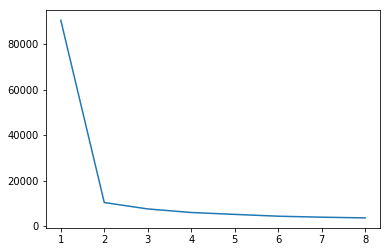

In [35]:
plt.plot(rev_grouped["diff_week"].value_counts())

In [122]:
df = pd.DataFrame(rev_grouped["diff_week"].value_counts())
df

,diff_week
1,90442
2,10317
3,7499
4,5937
5,5102
6,4309
7,3872
8,3554


In [182]:
x_axis = [1,2,3,4,5,6,7,8]
num_records_yob = [90442,10317,7499,5937,5102,4309,3872,3554]

In [128]:
rev_grouped["diff_week"].value_counts()

1    90442
2    10317
3     7499
4     5937
5     5102
6     4309
7     3872
8     3554
Name: diff_week, dtype: int64

In [144]:
def roundup(x):
    return 100 + int(math.ceil(x / 100.0)) * 100

[Text(0,0.5,'Blocked Users active in week'), Text(0.5,0,'Week #')]

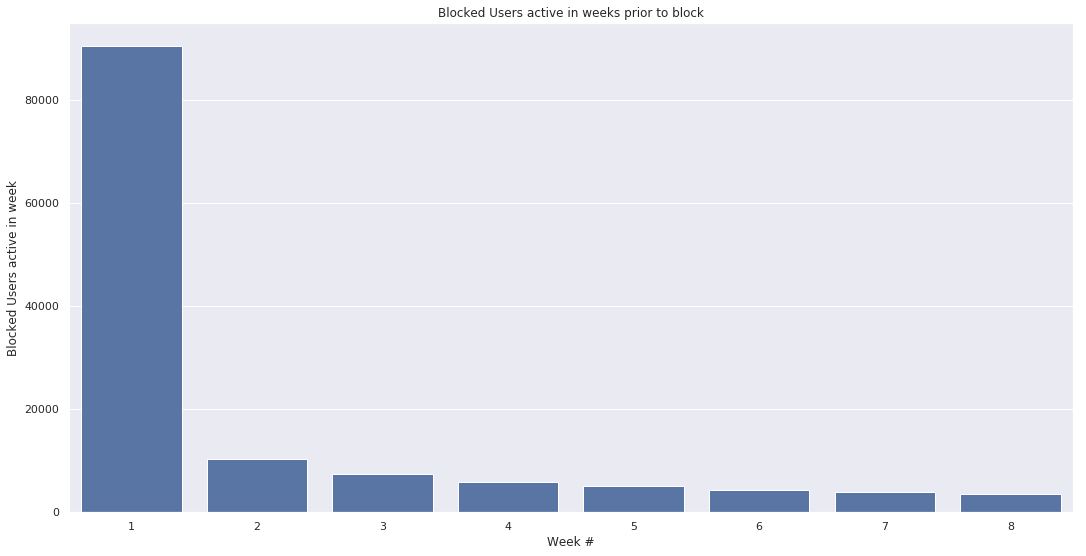

In [184]:
sns.set(style="darkgrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(18,9))
plt.ticklabel_format(style='plain', axis='y')
# Plot the total crashes
#sns.set_color_codes("pastel")
sns.barplot(x=x_axis, y=num_records_yob, color='b').set_title('Blocked Users active in weeks prior to block')
ax.set(ylabel="Blocked Users active in week",
       xlabel="Week #")

Users active during 1st week(prior to block)

In [26]:
rev_week_g["diff_days"].value_counts()

0    69985
1    22155
2     7482
3     5499
4     4520
5     4196
6     3827
Name: diff_days, dtype: int64

In [27]:
len(rev_week_g["rev_user_text"].unique())

90442

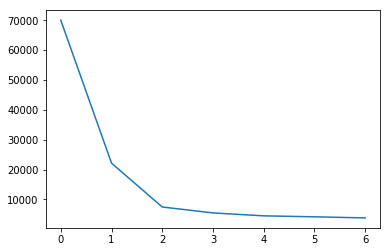

In [28]:
plt.plot(rev_week_g["diff_days"].value_counts())

In [186]:
x_axis = [0,1,2,3,4,5,6]
num_records_yob = [69985,22155,7482,5499,4520,4196,3827]

[Text(0,0.5,'Blocked Users active in week 1'), Text(0.5,0,'Day #')]

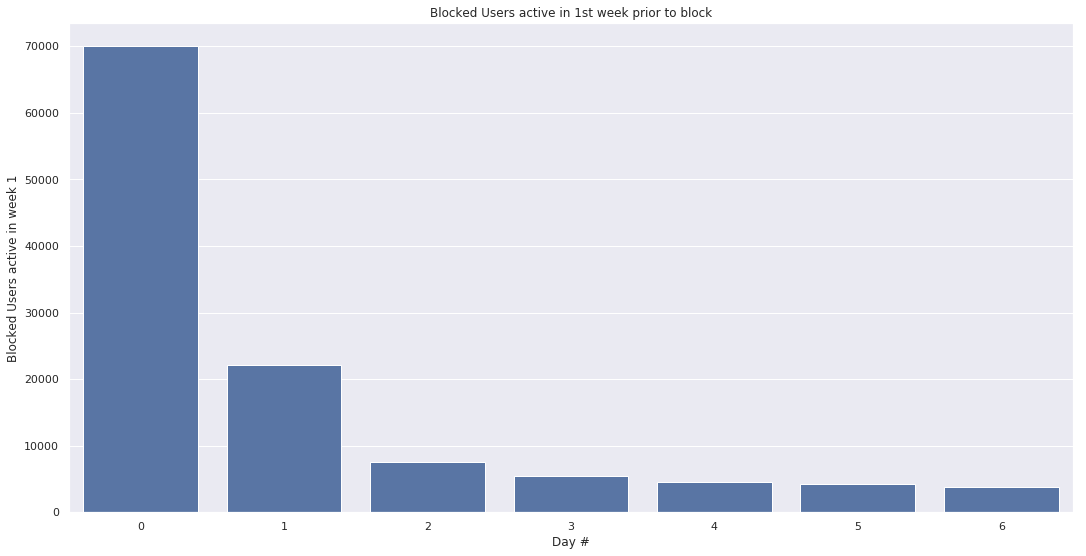

In [187]:
sns.set(style="darkgrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(18,9))
plt.ticklabel_format(style='plain', axis='y')
# Plot the total crashes
#sns.set_color_codes("pastel")
sns.barplot(x=x_axis, y=num_records_yob, color='b').set_title('Blocked Users active in 1st week prior to block')
#sns.set_color_codes("pastel")
ax.set(ylabel="Blocked Users active in week 1",
       xlabel="Day #")

### Non textual characteristics

In [ ]:
rev_grouped_plot=rev_grouped.rename(index=str, columns={"diff_week": "# week(s) before block","rev_deleted": "revisions deleted","rev_len": "average revision length", "rev_minor_edit": "minor edits", "rev_id": "revision count"})


In [75]:
rev_grouped_plot.head()

,rev_user_text,# week(s) before block,revision count,minor edits,revisions deleted,average revision length,ipb_address,keyword
0,!23455666A!wee,1,2,0,0,19934.50,!23455666A!wee,Account Block
1,!Cookiesarenice!,1,4,0,0,86042.75,!Cookiesarenice!,Vandalism
2,!D+lsamwks,1,2,2,0,18184.50,!D+lsamwks,Others
3,!Ideas,1,1,0,0,13170.00,!Ideas,Account Block
4,"$1,000,000 and a headline show in Las Vegas",1,4,0,0,136833.50,"$1,000,000 and a headline show in Las Vegas",Account Block


In [91]:
#df = pd.DataFrame(rev_grouped_plot.groupby(['keyword','# week(s) before block'],as_index=False)['revision count'].mean())
#df = df.sort_values('# week(s) before block', ascending = False)
#df

In [69]:
#rev_grouped_plot['# week(s) before block'] = rev_grouped_plot['# week(s) before block'].astype(str)

In [70]:
#num_order = ['8','7','6','5','4','3','2','1']
#rev_grouped_plot_v1 = rev_grouped_plot["# week(s) before block"].loc[num_order]

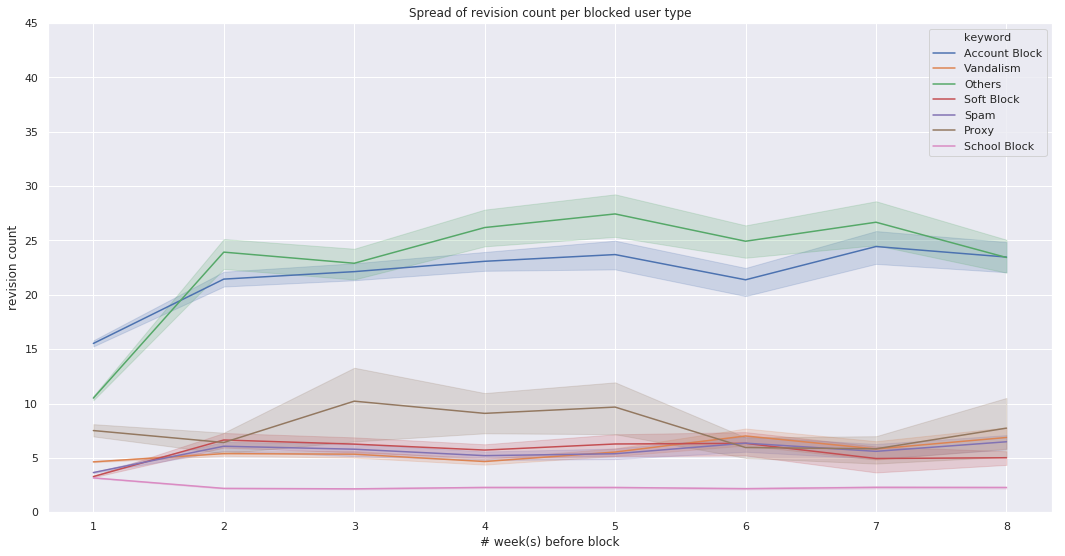

In [103]:
sns.set(style="darkgrid")
fig, ax = plt.subplots()
fig.set_size_inches(18,9)
ax.set_ylim([0,45])
fig1 = sns.lineplot(x='# week(s) before block',y='revision count',data=rev_grouped_plot,hue='keyword',estimator=np.mean,ci=50).set_title('Spread of revision count per blocked user type')

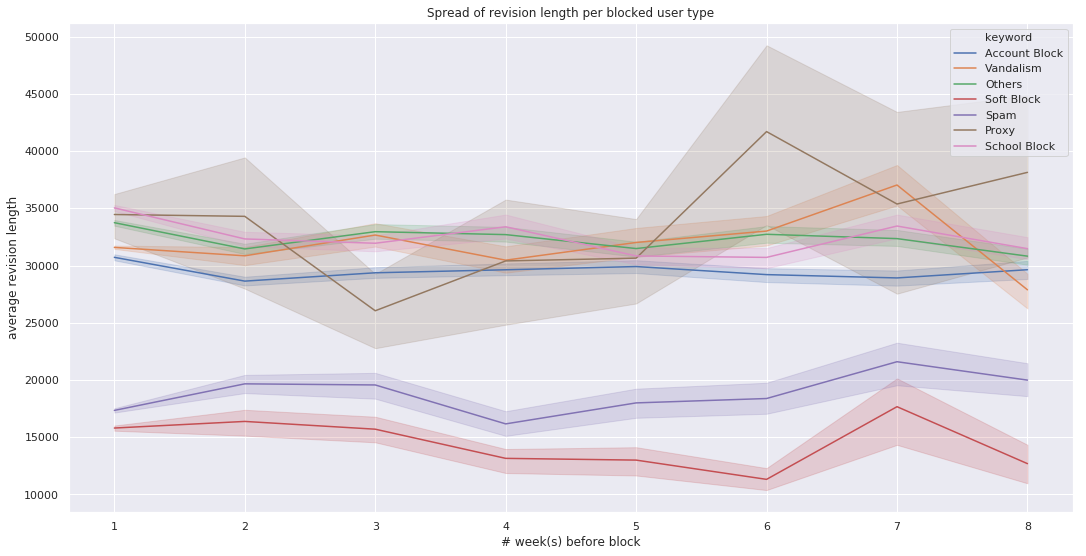

In [99]:
sns.set(style="darkgrid")
fig, ax = plt.subplots()
fig.set_size_inches(18,9)
#ax.set_ylim([0,45])
h2 = sns.lineplot(x='# week(s) before block',y='average revision length',data=rev_grouped_plot,hue='keyword',estimator=np.mean,ci=50).set_title('Spread of revision length per blocked user type')

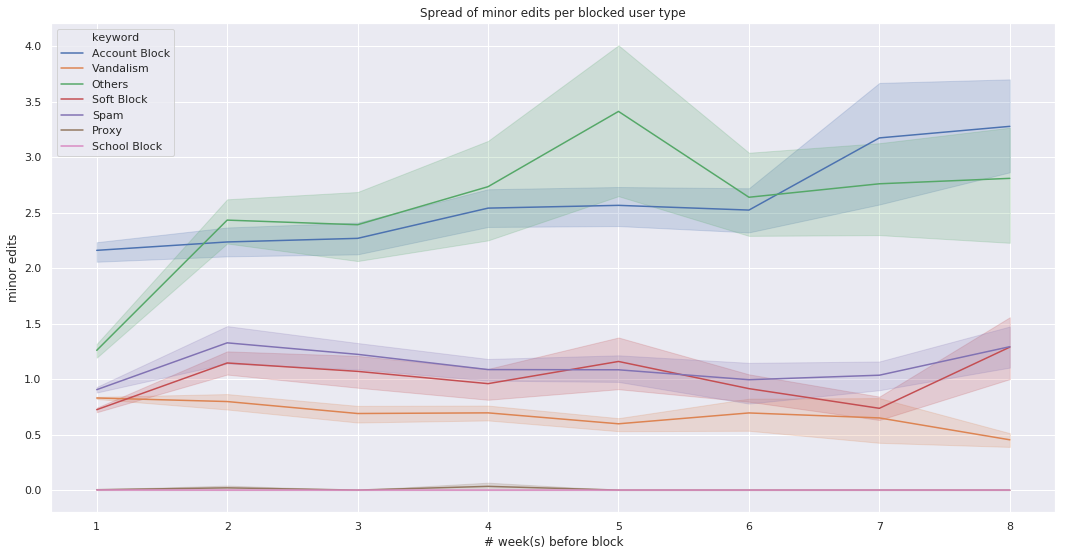

In [100]:
sns.set(style="darkgrid")
fig, ax = plt.subplots()
fig.set_size_inches(18,9)
#ax.set_ylim([0,45])
h3 = sns.lineplot(x='# week(s) before block',y='minor edits',data=rev_grouped_plot,hue='keyword',estimator=np.mean,ci=50).set_title('Spread of minor edits per blocked user type')

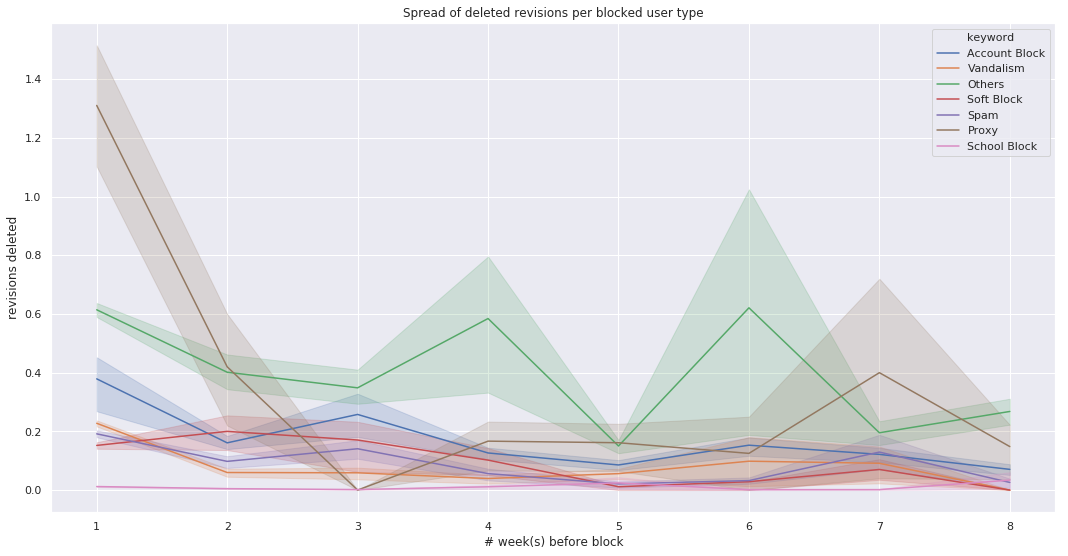

In [101]:
sns.set(style="darkgrid")
fig, ax = plt.subplots()
fig.set_size_inches(18,9)
#ax.set_ylim([0,45])
h4 = sns.lineplot(x='# week(s) before block',y='revisions deleted',data=rev_grouped_plot,hue='keyword',estimator=np.mean,ci=50).set_title('Spread of deleted revisions per blocked user type')